# Machine Learning Models For Motion Intention Using EMG Signals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import math
from utils import *
from mlModels import *

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.feature_selection as fs
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

import keras
import tensorflow as tf
from keras.models import load_model

In [2]:
keras.backend.clear_session()
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


## Load Data

In [3]:
w_length = 200
w_increment = 100

path = 'D:\Documentos\Datasets\Grabaciones 2 Corr'

raw_data, labels, angle, speed, torque = loadAndLabel(path, w_length, w_increment)

10_ext_0_31_62.txt
10_flex_0_31_62.txt
10_flex_1333_31_62.txt
10_flex_3638_31_62.txt
10_pron_0_4_62.txt
10_pron_919_4_62.txt
10_stat_0_31_62.txt
10_sup_0_4_62.txt
10_sup_919_4_62.txt
11_ext_0_29_48.txt
11_flex_0_29_48.txt
11_flex_1333_29_48.txt
11_flex_3638_29_48.txt
11_pron_0_3_48.txt
11_pron_919_3_48.txt
11_stat_0_29_48.txt
11_sup_0_3_48.txt
11_sup_919_3_48.txt
12_ext_0_31_66.txt
12_flex_0_31_66.txt
12_flex_1333_31_66.txt
12_flex_3638_31_66.txt
12_pron_0_5_66.txt
12_pron_919_5_66.txt
12_sup_0_5_66.txt
12_sup_919_5_66.txt
13_ext_0_31_70.txt
13_flex_0_31_70.txt
13_flex_1333_31_70.txt
13_flex_3638_31_70.txt
13_pron_0_5_70.txt
13_pron_919_5_70.txt
13_stat_0_5_70.txt
13_sup_0_5_70.txt
13_sup_919_5_70.txt
14_ext_0_29_4.txt
14_flex_0_29_4.txt
14_flex_1333_29_4.txt
14_flex_3638_29_4.txt
14_pron_0_4_48.txt
14_pron_919_4_48.txt
14_stat_0_4_48.txt
14_sup_919_4_48.txt
15_ext_0_29_54.txt
15_flex_0_29_54.txt
15_flex_1333_29_54.txt
15_flex_3638_29_54.txt
15_pron_0_4_54.txt
15_pron_919_4_54.txt
15_s

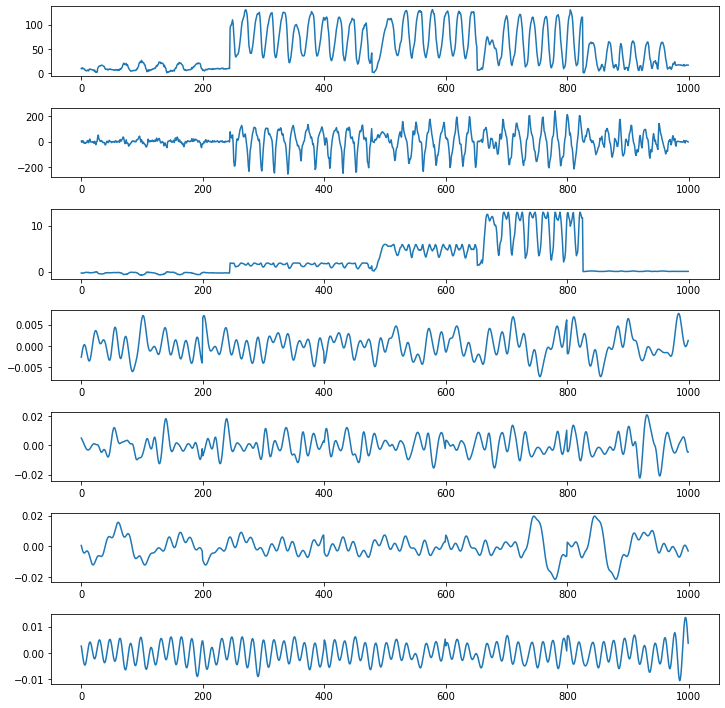

In [9]:
fig, axs = plt.subplots(7, figsize=(10,10))
fig.tight_layout()
plot_data_emg = np.vstack(raw_data)
plot_data_angle = np.vstack(angle)
plot_data_speed = np.vstack(speed)
plot_data_torque = np.vstack(torque)

n = 1000

axs[0].plot(plot_data_angle[0:n])
axs[1].plot(plot_data_speed[0:n])
axs[2].plot(plot_data_torque[0:n])
axs[3].plot(plot_data_emg[0:n,0])
axs[4].plot(plot_data_emg[0:n,1])
axs[5].plot(plot_data_emg[0:n,2])
axs[6].plot(plot_data_emg[0:n,3])

In [12]:
w, ch = raw_data[0].shape
print('Number of examples (m) = ', len(raw_data))
print('Window lenght (w) = ', w)
print('Number of EMG channels (ch) = ', ch)

Number of examples (m) =  22600
Window lenght (w) =  200
Number of EMG channels (ch) =  4


In [13]:
emg_raw_arr = np.array(raw_data)[:,:,0:4]
labels_arr = np.array(labels)
angle_arr = np.array(angle)
torque_arr = np.array(torque)
print(emg_raw_arr.shape)

(22600, 200, 4)


## EMG Features

In [14]:
f_emg_data = EMGfeatures(emg_raw_arr)

sc = MinMaxScaler()
trans = sc.fit_transform(f_emg_data)

print(f_emg_data.shape)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


(22600, 44)


## Moving Average Filter

In [15]:
maf_emg_data = maf(emg_raw_arr)

ascol = maf_emg_data.reshape(-1, ch)
sc = MinMaxScaler()
trans = sc.fit_transform(ascol)

maf_emg_data = trans.reshape(-1, w, ch)
print(maf_emg_data.shape)

maf_emg_data_flat = maf_emg_data.reshape(maf_emg_data.shape[0], w*ch)
print(maf_emg_data_flat.shape)

(22600, 200, 4)
(22600, 800)


## Autoencoder Feature Extraction

In [16]:
cnn_encoder = load_model('encoder_model.h5')
cnn_encoder.summary()

Model: "Convolutional_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 200, 4, 16)        272       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 2, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 2, 8)         520       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 1, 8)         0         
 2D)                                                             
                                                                 
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [17]:
cnn_encoder.compile(optimizer='adam', loss='binary_crossentropy')
ae_emg = cnn_encoder.predict(emg_raw_arr)
print(ae_emg.shape)

ae_emg_data = ae_emg.reshape(ae_emg.shape[0], ae_emg.shape[1], ae_emg.shape[3])
print(ae_emg_data.shape)

ae_emg_data_flat = ae_emg.reshape(ae_emg.shape[0], -1)
print(ae_emg_data_flat.shape)

707/707 [==============================] - 3s 947us/step
(22600, 50, 1, 8)
(22600, 50, 8)
(22600, 400)


## Data Split

In [18]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_maf, X_test_maf, Y_train_maf, Y_test_maf = train_test_split(maf_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_maf_flat, X_test_maf_flat, Y_train_maf_flat, Y_test_maf_flat = train_test_split(maf_emg_data_flat, labels_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_ae, X_test_ae, Y_train_ae, Y_test_ae = train_test_split(ae_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, labels_arr, stratify=labels, test_size=0.1, random_state=1)

# Classifiers Training

## EMG Features

In [18]:
models_classif, models_names_classif = sklearnModelsClassif()
train_scores, val_scores, cms = cvClassifiers(X_train_feat, Y_train_feat, models_classif, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [16]:
mlp_train_scores, mlp_val_scores = cvKeras(X_train_feat, Y_train_feat, mlp(), k = 5)
models_names_classif.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])

Epoch 1/200
627/627 [==============================] - 2s 3ms/step - loss: 15302.8203 - Accuracy: 0.4409
Epoch 2/200
627/627 [==============================] - 1s 2ms/step - loss: 59.3618 - Accuracy: 0.5721
Epoch 3/200
627/627 [==============================] - 1s 2ms/step - loss: 26.3280 - Accuracy: 0.6167
Epoch 4/200
627/627 [==============================] - 1s 2ms/step - loss: 8.7737 - Accuracy: 0.6392
Epoch 5/200
627/627 [==============================] - 1s 2ms/step - loss: 7.5414 - Accuracy: 0.6471
Epoch 6/200
627/627 [==============================] - 1s 2ms/step - loss: 3.3989 - Accuracy: 0.6580
Epoch 7/200
627/627 [==============================] - 1s 2ms/step - loss: 2.2033 - Accuracy: 0.6602
Epoch 8/200
627/627 [==============================] - 1s 2ms/step - loss: 3.7824 - Accuracy: 0.6684
Epoch 9/200
627/627 [==============================] - 1s 2ms/step - loss: 1.8196 - Accuracy: 0.6699
Epoch 10/200
627/627 [==============================] - 1s 2ms/step - loss: 2.6932 - 

In [17]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['Accuracy', 'F1-Score']],names=['','Model'])
models_comparison_classif = pd.DataFrame(zip(train_scores[0], train_scores[1], val_scores[0], val_scores[1]), index=models_names_classif, columns=cols)
models_comparison_classif = models_comparison_classif.sort_values([('Val', 'Accuracy')], ascending=False)
models_comparison_classif


Train                 Val          
Model                Accuracy  F1-Score  Accuracy  F1-Score
Random Forest        1.000000  1.000000  0.817892  0.847317
Bagging              0.990828  0.992203  0.786455  0.816660
Deep MLP             0.794085  0.826094  0.782145  0.814955
Gradient Boosting    0.802827  0.839063  0.771140  0.808127
MLP                  0.732030  0.759191  0.724032  0.751584
Decision Tree        1.000000  1.000000  0.714914  0.756309
Stacking             1.000000  1.000000  0.713926  0.756014
KNN                  0.716601  0.716550  0.568733  0.575176
Logistic Regression  0.524309  0.481533  0.522925  0.478973
AdaBoost             0.500626  0.427097  0.500427  0.428391
LDA                  0.477887  0.449312  0.478061  0.448318
Naive Bayes          0.362659  0.154579  0.362689  0.154588
SVM                  0.345614  0.112520  0.345444  0.112051

## Moving Average Filter

In [20]:
bg = BaggingClassifier()
rf = RandomForestClassifier()
models_classif = [bg,rf]
models_names_classif = ['Bagging','Random Forest']
train_scores, val_scores, cms = cvClassifiers(X_train_maf_flat, Y_train_maf_flat, models_classif, k=5)

In [21]:
mlp_train_scores, mlp_val_scores = cvKeras(X_train_maf_flat, Y_train_maf_flat, mlp(), k = 5)
models_names_classif.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])

Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 1.3187 - Accuracy: 0.4188
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 1.0635 - Accuracy: 0.5533
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 1.0065 - Accuracy: 0.5870
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.9745 - Accuracy: 0.5949
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.9493 - Accuracy: 0.6035
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.9280 - Accuracy: 0.6268
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.9075 - Accuracy: 0.6359
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.8886 - Accuracy: 0.6375
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.8769 - Accuracy: 0.6385
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.8645 - Accuracy: 0.6419
Epoch 11/

In [22]:
cnn_train_scores, cnn_val_scores = cvKeras(X_train_maf.reshape(X_train_maf.shape[0],w,ch,1), Y_train_maf, cnn(), k = 5)
models_names_classif.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])

Epoch 1/200
64/64 [==============================] - 2s 8ms/step - loss: 1.4717 - Accuracy: 0.3518
Epoch 2/200
64/64 [==============================] - 0s 5ms/step - loss: 1.2637 - Accuracy: 0.4463
Epoch 3/200
64/64 [==============================] - 0s 5ms/step - loss: 1.1117 - Accuracy: 0.5511
Epoch 4/200
64/64 [==============================] - 0s 5ms/step - loss: 1.0526 - Accuracy: 0.5753
Epoch 5/200
64/64 [==============================] - 0s 5ms/step - loss: 1.0244 - Accuracy: 0.5850
Epoch 6/200
64/64 [==============================] - 0s 5ms/step - loss: 0.9990 - Accuracy: 0.5928
Epoch 7/200
64/64 [==============================] - 0s 5ms/step - loss: 0.9722 - Accuracy: 0.6011
Epoch 8/200
64/64 [==============================] - 0s 5ms/step - loss: 0.9488 - Accuracy: 0.6057
Epoch 9/200
64/64 [==============================] - 0s 5ms/step - loss: 0.9322 - Accuracy: 0.6086
Epoch 10/200
64/64 [==============================] - 0s 5ms/step - loss: 0.9136 - Accuracy: 0.6228
Epoch 11/

In [24]:
lstm_train_scores, lstm_val_scores = cvKeras(X_train_maf, Y_train_maf, lstm_rnn(), k = 5)
models_names_classif.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])

Epoch 1/200
64/64 [==============================] - 2s 18ms/step - loss: 1.4779 - Accuracy: 0.3382
Epoch 2/200
64/64 [==============================] - 1s 15ms/step - loss: 1.2716 - Accuracy: 0.4404
Epoch 3/200
64/64 [==============================] - 1s 15ms/step - loss: 1.1557 - Accuracy: 0.5065
Epoch 4/200
64/64 [==============================] - 1s 14ms/step - loss: 1.0976 - Accuracy: 0.5352
Epoch 5/200
64/64 [==============================] - 1s 14ms/step - loss: 1.0642 - Accuracy: 0.5480
Epoch 6/200
64/64 [==============================] - 1s 14ms/step - loss: 1.0553 - Accuracy: 0.5514
Epoch 7/200
64/64 [==============================] - 1s 15ms/step - loss: 1.0271 - Accuracy: 0.5677
Epoch 8/200
64/64 [==============================] - 1s 15ms/step - loss: 1.0207 - Accuracy: 0.5676
Epoch 9/200
64/64 [==============================] - 1s 15ms/step - loss: 1.0156 - Accuracy: 0.5688
Epoch 10/200
64/64 [==============================] - 1s 15ms/step - loss: 1.0044 - Accuracy: 0.5782

In [25]:
gru_train_scores, gru_val_scores = cvKeras(X_train_maf, Y_train_maf, gru_rnn(), k = 5)
models_names_classif.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])

Epoch 1/200
64/64 [==============================] - 2s 15ms/step - loss: 1.4941 - Accuracy: 0.3362
Epoch 2/200
64/64 [==============================] - 1s 14ms/step - loss: 1.3393 - Accuracy: 0.3849
Epoch 3/200
64/64 [==============================] - 1s 14ms/step - loss: 1.2039 - Accuracy: 0.4737
Epoch 4/200
64/64 [==============================] - 1s 14ms/step - loss: 1.1303 - Accuracy: 0.5198
Epoch 5/200
64/64 [==============================] - 1s 14ms/step - loss: 1.0949 - Accuracy: 0.5254
Epoch 6/200
64/64 [==============================] - 1s 14ms/step - loss: 1.0675 - Accuracy: 0.5361
Epoch 7/200
64/64 [==============================] - 1s 14ms/step - loss: 1.0538 - Accuracy: 0.5436
Epoch 8/200
64/64 [==============================] - 1s 14ms/step - loss: 1.0476 - Accuracy: 0.5478
Epoch 9/200
64/64 [==============================] - 1s 14ms/step - loss: 1.0432 - Accuracy: 0.5494
Epoch 10/200
64/64 [==============================] - 1s 13ms/step - loss: 1.0324 - Accuracy: 0.5610

In [26]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['Accuracy', 'F1-Score']],names=['','Model'])
models_comparison_classif = pd.DataFrame(zip(train_scores[0], train_scores[1], val_scores[0], val_scores[1]), index=models_names_classif, columns=cols)
models_comparison_classif = models_comparison_classif.sort_values([('Val', 'Accuracy')], ascending=False)
models_comparison_classif

Train                 Val          
Model          Accuracy  F1-Score  Accuracy  F1-Score
GRU            0.707055  0.735250  0.695772  0.723162
CNN            0.723242  0.747465  0.686382  0.711149
LSTM           0.689516  0.711184  0.682006  0.703378
Deep MLP       0.727102  0.754736  0.681318  0.710688
Random Forest  1.000000  1.000000  0.674582  0.704324
Bagging        0.989049  0.990107  0.629204  0.657674

## Autoencoder Feature Extraction

In [27]:
bg = BaggingClassifier()
rf = RandomForestClassifier()
models_classif = [bg,rf]
models_names_classif = ['Bagging','Random Forest']
train_scores, val_scores, cms = cvClassifiers(X_train_ae_flat, Y_train_ae_flat, models_classif, k=5)

In [28]:
mlp_train_scores, mlp_val_scores = cvKeras(X_train_ae_flat, Y_train_ae_flat, mlp(), k = 5)
models_names_classif.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])

Epoch 1/200
64/64 [==============================] - 0s 3ms/step - loss: 1.4333 - Accuracy: 0.3312
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 1.3279 - Accuracy: 0.4087
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 1.2513 - Accuracy: 0.4791
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 1.1928 - Accuracy: 0.4995
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 1.1522 - Accuracy: 0.5104
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 1.1164 - Accuracy: 0.5277
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 1.0861 - Accuracy: 0.5422
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 1.0596 - Accuracy: 0.5527
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 1.0368 - Accuracy: 0.5611
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 1.0183 - Accuracy: 0.5788
Epoch 11/

In [29]:
cnn_train_scores, cnn_val_scores = cvKeras(X_train_ae.reshape(X_train_ae.shape[0],X_train_ae.shape[1],X_train_ae.shape[2],1), Y_train_ae, cnn(), k = 5)
models_names_classif.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])

Epoch 1/200
64/64 [==============================] - 1s 6ms/step - loss: 1.4706 - Accuracy: 0.3371
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 1.3982 - Accuracy: 0.3633
Epoch 3/200
64/64 [==============================] - 0s 4ms/step - loss: 1.3174 - Accuracy: 0.3777
Epoch 4/200
64/64 [==============================] - 0s 5ms/step - loss: 1.1706 - Accuracy: 0.5088
Epoch 5/200
64/64 [==============================] - 0s 4ms/step - loss: 1.0948 - Accuracy: 0.5335
Epoch 6/200
64/64 [==============================] - 0s 4ms/step - loss: 1.0591 - Accuracy: 0.5384
Epoch 7/200
64/64 [==============================] - 0s 4ms/step - loss: 1.0208 - Accuracy: 0.5683
Epoch 8/200
64/64 [==============================] - 0s 4ms/step - loss: 0.9637 - Accuracy: 0.6177
Epoch 9/200
64/64 [==============================] - 0s 4ms/step - loss: 0.9384 - Accuracy: 0.6211
Epoch 10/200
64/64 [==============================] - 0s 5ms/step - loss: 0.9237 - Accuracy: 0.6232
Epoch 11/

In [30]:
lstm_train_scores, lstm_val_scores = cvKeras(X_train_ae, Y_train_ae, lstm_rnn(), k = 5)
models_names_classif.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])

Epoch 1/200
64/64 [==============================] - 2s 8ms/step - loss: 1.4955 - Accuracy: 0.3022
Epoch 2/200
64/64 [==============================] - 0s 7ms/step - loss: 1.2733 - Accuracy: 0.4258
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 1.1836 - Accuracy: 0.5066
Epoch 4/200
64/64 [==============================] - 0s 7ms/step - loss: 1.1279 - Accuracy: 0.5356
Epoch 5/200
64/64 [==============================] - 0s 7ms/step - loss: 1.1077 - Accuracy: 0.5390
Epoch 6/200
64/64 [==============================] - 0s 7ms/step - loss: 1.0897 - Accuracy: 0.5487
Epoch 7/200
64/64 [==============================] - 0s 7ms/step - loss: 1.0745 - Accuracy: 0.5483
Epoch 8/200
64/64 [==============================] - 0s 7ms/step - loss: 1.0573 - Accuracy: 0.5615
Epoch 9/200
64/64 [==============================] - 0s 7ms/step - loss: 1.0366 - Accuracy: 0.5662
Epoch 10/200
64/64 [==============================] - 0s 7ms/step - loss: 1.0229 - Accuracy: 0.5675
Epoch 11/

In [31]:
gru_train_scores, gru_val_scores = cvKeras(X_train_ae, Y_train_ae, gru_rnn(), k = 5)
models_names_classif.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])

Epoch 1/200
64/64 [==============================] - 2s 8ms/step - loss: 1.4958 - Accuracy: 0.3073
Epoch 2/200
64/64 [==============================] - 0s 7ms/step - loss: 1.3921 - Accuracy: 0.3394
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 1.3003 - Accuracy: 0.4028
Epoch 4/200
64/64 [==============================] - 0s 6ms/step - loss: 1.1677 - Accuracy: 0.5133
Epoch 5/200
64/64 [==============================] - 0s 7ms/step - loss: 1.0921 - Accuracy: 0.5455
Epoch 6/200
64/64 [==============================] - 0s 6ms/step - loss: 1.0663 - Accuracy: 0.5545
Epoch 7/200
64/64 [==============================] - 0s 6ms/step - loss: 1.0623 - Accuracy: 0.5526
Epoch 8/200
64/64 [==============================] - 0s 6ms/step - loss: 1.0523 - Accuracy: 0.5584
Epoch 9/200
64/64 [==============================] - 0s 7ms/step - loss: 1.0478 - Accuracy: 0.5598
Epoch 10/200
64/64 [==============================] - 0s 7ms/step - loss: 1.0402 - Accuracy: 0.5622
Epoch 11/

In [32]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['Accuracy', 'F1-Score']],names=['','Model'])
models_comparison_classif = pd.DataFrame(zip(train_scores[0], train_scores[1], val_scores[0], val_scores[1]), index=models_names_classif, columns=cols)
models_comparison_classif = models_comparison_classif.sort_values([('Val', 'Accuracy')], ascending=False)
models_comparison_classif

Train                 Val          
Model          Accuracy  F1-Score  Accuracy  F1-Score
CNN            0.781662  0.803346  0.742970  0.768765
LSTM           0.749312  0.776013  0.729941  0.756030
GRU            0.750369  0.774605  0.729400  0.752337
Deep MLP       0.795465  0.803276  0.677237  0.697192
Random Forest  1.000000  1.000000  0.570551  0.562522
Bagging        0.991949  0.992420  0.512045  0.524796

# Feature selection and extraction

## Principal Component Analysis

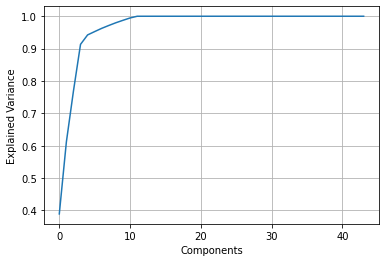

In [38]:
pca = PCA().fit(f_emg_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.grid(True)

Text(0, 0.5, 'Component 2')

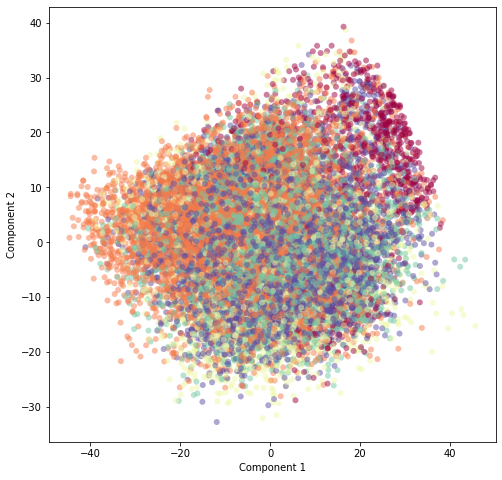

In [39]:
pca = PCA(2)
projected = pca.fit_transform(f_emg_data)
plt.figure(figsize=(8,8))
plt.scatter(projected[:,0], projected[:,1],
            c=labels_arr, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')

## Filter selection - Select K Best

In [ ]:
f1_list = []
accuracy_list=[]
for k in range(1, X.shape[1]):

  bk = fs.SelectKBest(fs.f_classif, k=k)
  bk.fit(X_train, Y_train)

  X_train_trans = bk.transform(X_train)
  X_test_trans = bk.transform(X_test)

  lr = RandomForestClassifier()
  lr.fit(X_train_trans, Y_train)

  y_pred = lr.predict(X_test_trans)
  accuracy = accuracy_score(Y_test, y_pred)
  accuracy_list.append(accuracy)
  f1 = f1_score(Y_test, y_pred, average='macro')
  f1_list.append(f1)

fig, axe = plt.subplots(1,2,figsize=(15,5))
axe[0].plot(range(1, X.shape[1]), accuracy_list)
axe[0].set_xlabel("Mejores k rasgos")
axe[0].set_ylabel("Accuracy")
axe[1].plot(range(1, X.shape[1]), f1_list)
axe[1].set_xlabel("Mejores k rasgos")
axe[1].set_ylabel("F1-score")
plt.show()
print(np.argmax(accuracy_list))
print(max(accuracy_list))
print(max(f1_list))

# Hyperparameter Optimization